# Employment Statistics

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Functions

In [2]:
WIDTH = 14
def plotTimeSeries(data, col, title):
    if col != '':   # dataframe
        data[col].plot(figsize=(WIDTH, 4))
    else:           # series
        data.plot(figsize=(WIDTH, 4))
    plt.legend(loc='best');plt.title(title);plt.show(block=False)

y_hat = pd.DataFrame()
def recoverOriginalSeries(model_fit, data_boxcox_diff, data_boxcox, model):
    global y_hat
    print(y_hat.shape[0])
    y_hat[f'{model}_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
    y_hat[f'{model}_forecast_boxcox']      = y_hat[f'{model}_forecast_boxcox_diff'].cumsum()
    y_hat[f'{model}_forecast_boxcox']      = y_hat[f'{model}_forecast_boxcox'].add(data_boxcox[0])
    y_hat[f'{model}_forecast']             = np.exp(y_hat[f'{model}_forecast_boxcox'])
    print(y_hat.shape[0])

def plotTrainTestSeries(train, test, model, title):
    plt.figure(figsize=(WIDTH,4))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    print(test.index.min())
    plt.plot(y_hat[f'{model}_forecast'][test.index.min():], label=f'{title} forecast')
    plt.legend(loc='best')
    plt.title(f'{title} Method')
    plt.show()

## Read and inspect the time series

In [3]:
df_emp = pd.read_csv("data/unrate.csv",header=None);
df_emp.columns = ['DATE', 'UNRATE']
df_emp.set_index('DATE')
COL = "UNRATE"
LEN = 612
print(df_emp.shape[0], df_emp[COL].isnull().sum(), df_emp[COL].mean())
df_emp.head()

867 0 5.727220299884659


,DATE,UNRATE
0,01-01-1948,3.4
1,01-02-1948,3.8
2,01-03-1948,4.0
3,01-04-1948,3.9
4,01-05-1948,3.5


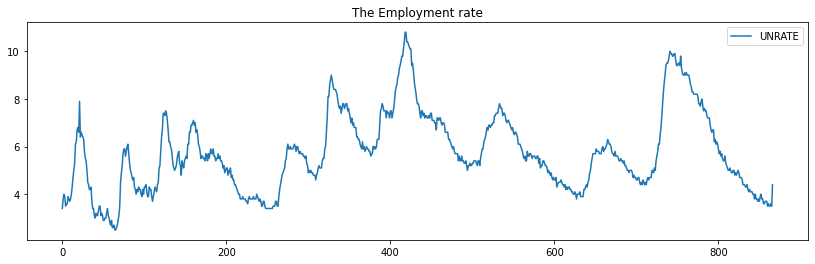

In [4]:
plotTimeSeries(df_emp, COL, 'The Employment rate')

There is some seasonality. Trend?? Stationarity? Autocorrelation?

## Stationarity Test

In [5]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

adf_test = adfuller(df_emp[COL])
print('ADF Statistic: %f' % adf_test[0], 'Critical Values @ 0.05: %.2f' % adf_test[4]['5%'], 'p-value: %f' % adf_test[1])
kpss_test = kpss(df_emp[COL])
print('KPSS Statistic: %f' % kpss_test[0], 'Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'], 'p-value: %f' % kpss_test[1])

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ADF Statistic: -3.143963 Critical Values @ 0.05: -2.86 p-value: 0.023466
KPSS Statistic: 0.464446 Critical Values @ 0.05: 0.46 p-value: 0.049674


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


This time series is not statioanry

## Make it stationary - remove variance and trend

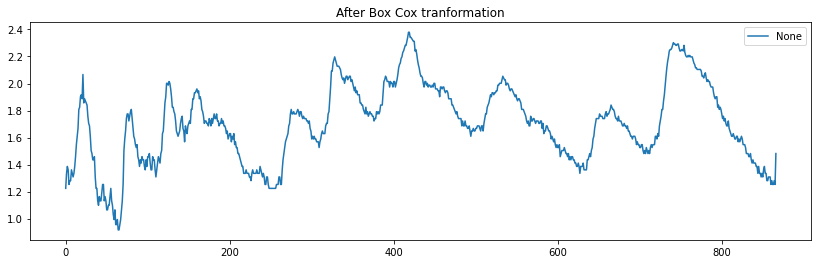

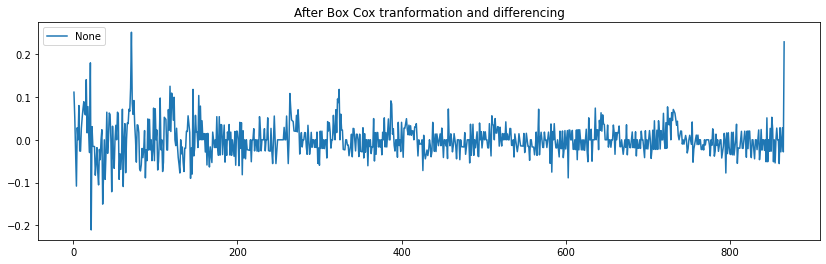

1    0.111226
2    0.051293
3   -0.025318
4   -0.108214
5    0.028171
dtype: float64

In [6]:
from scipy.stats import boxcox
data_emp_boxcox = pd.Series(boxcox(df_emp[COL], lmbda=0), index=df_emp.index)
plotTimeSeries(data_emp_boxcox, '','After Box Cox tranformation')

data_emp_boxcox_diff = pd.Series(data_emp_boxcox - data_emp_boxcox.shift(), index=df_emp.index)
plotTimeSeries(data_emp_boxcox_diff, '','After Box Cox tranformation and differencing')
data_emp_boxcox_diff.dropna(inplace=True)

data_emp_boxcox_diff.head()

In [7]:
adf_test = adfuller(data_emp_boxcox_diff)
print('ADF Statistic: %f' % adf_test[0], 'Critical Values @ 0.05: %.2f' % adf_test[4]['5%'], 'p-value: %f' % adf_test[1])
kpss_test = kpss(data_emp_boxcox_diff)
print('KPSS Statistic: %f' % kpss_test[0], 'Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'], 'p-value: %f' % kpss_test[1])

ADF Statistic: -8.918955 Critical Values @ 0.05: -2.86 p-value: 0.000000
KPSS Statistic: 0.062761 Critical Values @ 0.05: 0.46 p-value: 0.100000


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Time series is stationary

## Split the data into train and test sets

In [8]:
df_emp_train = df_emp[:LEN]; df_emp_test  = df_emp[LEN:]

data_emp_boxcox_train = data_emp_boxcox[:LEN]; data_emp_boxcox_test  = data_emp_boxcox[LEN:]
data_emp_boxcox_diff_train = data_emp_boxcox_diff[:LEN-1]; data_emp_boxcox_diff_test  = data_emp_boxcox_diff[LEN-1:]

data_emp_boxcox_diff_train.head()

1    0.111226
2    0.051293
3   -0.025318
4   -0.108214
5    0.028171
dtype: float64

In [9]:
print("df_emp", df_emp.shape[0], df_emp_train.shape[0], df_emp_test.shape[0])
print("data_emp_boxcox", data_emp_boxcox.shape[0], data_emp_boxcox_train.shape[0], data_emp_boxcox_test.shape[0])
print("data_emp_boxcox_diff", data_emp_boxcox_diff.shape[0], data_emp_boxcox_diff_train.shape[0], data_emp_boxcox_diff_test.shape[0])

df_emp 867 612 255
data_emp_boxcox 867 612 255
data_emp_boxcox_diff 866 611 255


In [10]:
df_emp_test.head()

,DATE,UNRATE
612,01-01-1999,4.3
613,01-02-1999,4.4
614,01-03-1999,4.2
615,01-04-1999,4.3
616,01-05-1999,4.2


## Auto regression method (AR)

In [11]:
from statsmodels.tsa.arima_model import ARIMA
# order = (p,d,q)
model = ARIMA(data_emp_boxcox_diff_train, order=(12, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.83910D+00    |proj g|=  1.59090D-01

At iterate    5    f= -1.84020D+00    |proj g|=  1.82704D-01

At iterate   10    f= -1.84027D+00    |proj g|=  1.38677D-02

At iterate   15    f= -1.84033D+00    |proj g|=  1.34621D-03

At iterate   20    f= -1.84034D+00    |proj g|=  2.00480D-03

At iterate   25    f= -1.84034D+00    |proj g|=  4.72267D-04

At iterate   30    f= -1.84034D+00    |proj g|=  2.88880D-05

At iterate   35    f= -1.84034D+00    |proj g|=  2.35367D-06

At iterate   40    f= -1.84034D+00    |proj g|=  1.99840D-05

At iterate   45    f= -1.84034D+00    |proj g|=  2.08722D-06

At iterate   50    f= -1.84034D+00    |proj g|=  7.54952D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [12]:
'''y_hat_ar = data_emp_boxcox_diff.copy().to_frame()
print(y_hat.shape[0])
y_hat_ar[f'{model}_forecast_boxcox_diff'] = model_fit.predict(data_emp_boxcox_diff.index.min(), data_emp_boxcox_diff.index.max())
y_hat_ar[f'{model}_forecast_boxcox']      = y_hat_ar[f'{model}_forecast_boxcox_diff'].cumsum()
y_hat_ar[f'{model}_forecast_boxcox']      = y_hat_ar[f'{model}_forecast_boxcox'].add(data_emp_boxcox[0])
y_hat_ar[f'{model}_forecast']             = np.exp(y_hat_ar[f'{model}_forecast_boxcox'])
print(y_hat_ar.shape[0])

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(df_emp_test[COL], y_hat['ar_forecast'][LEN-1:])).round(2)
mape = np.round(np.mean(np.abs(df_emp_test[COL]-y_hat['ar_forecast'][LEN-1:])/df_emp_test[COL])*100,2)

print('Method', 'Autoregressive (AR)', 'MAPE', mape, 'RMSE', rmse)
df_emp[df_emp['DATE']=='01-06-1948']['UNRATE']'''

"y_hat_ar = data_emp_boxcox_diff.copy().to_frame()\nprint(y_hat.shape[0])\ny_hat_ar[f'{model}_forecast_boxcox_diff'] = model_fit.predict(data_emp_boxcox_diff.index.min(), data_emp_boxcox_diff.index.max())\ny_hat_ar[f'{model}_forecast_boxcox']      = y_hat_ar[f'{model}_forecast_boxcox_diff'].cumsum()\ny_hat_ar[f'{model}_forecast_boxcox']      = y_hat_ar[f'{model}_forecast_boxcox'].add(data_emp_boxcox[0])\ny_hat_ar[f'{model}_forecast']             = np.exp(y_hat_ar[f'{model}_forecast_boxcox'])\nprint(y_hat_ar.shape[0])\n\nfrom sklearn.metrics import mean_squared_error\nrmse = np.sqrt(mean_squared_error(df_emp_test[COL], y_hat['ar_forecast'][LEN-1:])).round(2)\nmape = np.round(np.mean(np.abs(df_emp_test[COL]-y_hat['ar_forecast'][LEN-1:])/df_emp_test[COL])*100,2)\n\nprint('Method', 'Autoregressive (AR)', 'MAPE', mape, 'RMSE', rmse)\ndf_emp[df_emp['DATE']=='01-06-1948']['UNRATE']"

In [13]:
recoverOriginalSeries(model_fit, data_emp_boxcox_diff, data_emp_boxcox, 'ar' ); y_hat.head()

0
866


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,ar_forecast_boxcox_diff,ar_forecast_boxcox,ar_forecast
1,0.015034,1.238809,3.451502
2,0.030307,1.269116,3.557708
3,0.025443,1.294559,3.649388
4,0.005284,1.299844,3.668723
5,-0.007426,1.292418,3.641580


612


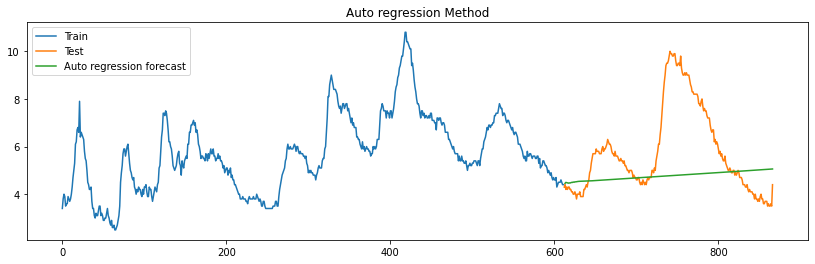

In [14]:
plotTrainTestSeries(df_emp_train[COL], df_emp_test[COL], 'ar', 'Auto regression')

In [15]:
data_emp_boxcox_diff.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            857, 858, 859, 860, 861, 862, 863, 864, 865, 866],
           dtype='int64', length=866)

In [16]:
print(df_emp.shape[0], df_emp_train.shape[0], df_emp_test.shape[0])

print(data_emp_boxcox.shape[0], data_emp_boxcox_train.shape[0], data_emp_boxcox_test.shape[0])
print(data_emp_boxcox_diff.shape[0], data_emp_boxcox_diff_train.shape[0], data_emp_boxcox_diff_test.shape[0])

print(y_hat.shape[0], y_hat[data_emp_boxcox_diff.index.min()-1:].shape[0], y_hat[:data_emp_boxcox_diff.index.max()].shape[0])
print(y_hat[data_emp_boxcox_diff.index.min()-1:data_emp_boxcox_diff.index.max()].shape[0])

867 612 255
867 612 255
866 611 255
866 866 866
866


In [17]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(df_emp_test[COL], y_hat['ar_forecast'][LEN-1:])).round(2)
mape = np.round(np.mean(np.abs(df_emp_test[COL]-y_hat['ar_forecast'][LEN-1:])/df_emp_test[COL])*100,2)

results = pd.DataFrame({'Method':['Autoregressive (AR)'], 'MAPE': [mape], 'RMSE': [rmse]})
#results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,MAPE,RMSE
0,Autoregressive (AR),21.5,2.07


In [18]:
df_emp[df_emp['DATE']=='01-06-1948']['UNRATE']

5    3.6
Name: UNRATE, dtype: float64

In [19]:
df_emp.head(6)

,DATE,UNRATE
0,01-01-1948,3.4
1,01-02-1948,3.8
2,01-03-1948,4.0
3,01-04-1948,3.9
4,01-05-1948,3.5
5,01-06-1948,3.6


In [20]:
y_hat.head(7)

,ar_forecast_boxcox_diff,ar_forecast_boxcox,ar_forecast
1,0.015034,1.238809,3.451502
2,0.030307,1.269116,3.557708
3,0.025443,1.294559,3.649388
4,0.005284,1.299844,3.668723
5,-0.007426,1.292418,3.641580
6,-0.006571,1.285846,3.617729
7,-0.011036,1.274811,3.578024


In [21]:
y_hat.loc[6,'ar_forecast']

3.617728818688098

## Moving Average (MA)

In [22]:
model = ARIMA(data_emp_boxcox_diff_train, order=(0, 0, 5)) 
model_fit = model.fit()
print(model_fit.params)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.81288D+00    |proj g|=  9.98799D-03

At iterate    5    f= -1.81289D+00    |proj g|=  6.68354D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     15      1     0     0   8.882D-08  -1.813D+00
  F =  -1.8128882167978566     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123452
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
 This problem is unconstrained.


In [23]:
recoverOriginalSeries(model_fit, data_emp_boxcox_diff, data_emp_boxcox, 'ma'); y_hat.head()

866
866


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,ar_forecast_boxcox_diff,ar_forecast_boxcox,ar_forecast,ma_forecast_boxcox_diff,ma_forecast_boxcox,ma_forecast
1,0.015034,1.238809,3.451502,0.012303,1.236078,3.442087
2,0.030307,1.269116,3.557708,0.026871,1.262949,3.535834
3,0.025443,1.294559,3.649388,0.020794,1.283743,3.610126
4,0.005284,1.299844,3.668723,-0.000387,1.283356,3.608730
5,-0.007426,1.292418,3.641580,-0.007650,1.275706,3.581228


612


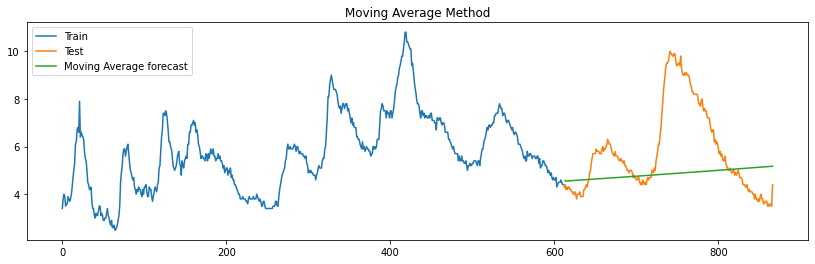

In [24]:
plotTrainTestSeries(df_emp_train[COL], df_emp_test[COL], 'ma', 'Moving Average')

In [25]:
rmse = np.sqrt(mean_squared_error(df_emp_test[COL], y_hat['ma_forecast'][LEN-1:])).round(2)
mape = np.round(np.mean(np.abs(df_emp_test[COL]-y_hat['ma_forecast'][LEN-1:])/df_emp_test[COL])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA)'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR),2.07,21.5
0,Moving Average (MA),2.03,21.6


In [26]:
y_hat.head(6)

,ar_forecast_boxcox_diff,ar_forecast_boxcox,ar_forecast,ma_forecast_boxcox_diff,ma_forecast_boxcox,ma_forecast
1,0.015034,1.238809,3.451502,0.012303,1.236078,3.442087
2,0.030307,1.269116,3.557708,0.026871,1.262949,3.535834
3,0.025443,1.294559,3.649388,0.020794,1.283743,3.610126
4,0.005284,1.299844,3.668723,-0.000387,1.283356,3.608730
5,-0.007426,1.292418,3.641580,-0.007650,1.275706,3.581228
6,-0.006571,1.285846,3.617729,-0.008622,1.267084,3.550484


In [27]:
y_hat.loc[6,'ma_forecast']

3.5504839615642556

## ARIMA

In [28]:
model = ARIMA(data_emp_boxcox_train, order=(12, 1, 5)) 
model_fit = model.fit()
print(model_fit.params)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.83730D+00    |proj g|=  2.90712D-01

At iterate    5    f= -1.83763D+00    |proj g|=  2.63622D-01

At iterate   10    f= -1.83865D+00    |proj g|=  1.13124D-02

At iterate   15    f= -1.83869D+00    |proj g|=  3.06210D-02

At iterate   20    f= -1.83870D+00    |proj g|=  3.16455D-02

At iterate   25    f= -1.83876D+00    |proj g|=  3.37337D-02

At iterate   30    f= -1.83877D+00    |proj g|=  2.00038D-02

At iterate   35    f= -1.83887D+00    |proj g|=  7.92615D-02

At iterate   40    f= -1.84016D+00    |proj g|=  1.28346D-02

At iterate   45    f= -1.84079D+00    |proj g|=  1.38652D-01

At iterate   50    f= -1.84363D+00    |proj g|=  1.06547D-01

At iterate   55    f= -1.84438D+00    |proj g|=  6.19605D-02

At iterate   60    f= -1.84466D+00    |proj g|=  9.13673D-02

At iterate   65    f= -1.8

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [29]:
y_hat_arima = data_emp_boxcox_diff.copy().to_frame()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_emp_boxcox_diff.index.min(), data_emp_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_emp_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

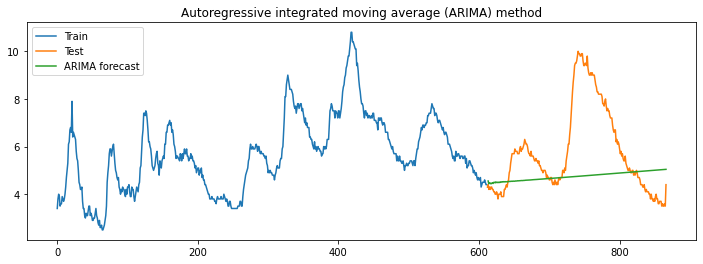

In [30]:
plt.figure(figsize=(12,4))
plt.plot(df_emp_train[COL], label='Train')
plt.plot(df_emp_test[COL], label='Test')
plt.plot(y_hat_arima['arima_forecast'][df_emp_test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

In [31]:
df_emp_test.index.min(), df_emp_test.index.max(), df_emp_test[COL][:-1].shape[0], y_hat_arima['arima_forecast'][df_emp_test.index.min()-1:-1].shape[0]

(612, 866, 254, 254)

In [32]:
rmse = np.sqrt(mean_squared_error(df_emp_test[COL][:-1], y_hat_arima['arima_forecast'][df_emp_test.index.min()-1:-1])).round(2)
mape = np.round(np.mean(np.abs(df_emp_test[COL]-y_hat_arima['arima_forecast'][df_emp_test.index.min():])/df_emp_test[COL])*100,2)

tempResults = pd.DataFrame({'Method':['ARIMA'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR),2.07,21.50
0,Moving Average (MA),2.03,21.60
0,ARIMA,2.08,21.62


## SARIMA

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data_emp_boxcox_train, order=(2, 1, 4), seasonal_order=(2, 1, 4, 12)) 
model_fit = model.fit()
print(model_fit.params)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63003D+00    |proj g|=  8.50682D+00

At iterate    5    f= -1.72966D+00    |proj g|=  2.74967D+00

At iterate   10    f= -1.74416D+00    |proj g|=  4.04048D-01

At iterate   15    f= -1.75018D+00    |proj g|=  1.31293D+00

At iterate   20    f= -1.75175D+00    |proj g|=  7.66684D-02

At iterate   25    f= -1.75311D+00    |proj g|=  4.09091D-02

At iterate   30    f= -1.75354D+00    |proj g|=  6.10218D-01

At iterate   35    f= -1.75475D+00    |proj g|=  4.94823D-02

At iterate   40    f= -1.75692D+00    |proj g|=  4.10656D-01

At iterate   45    f= -1.75843D+00    |proj g|=  1.39226D-02


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



At iterate   50    f= -1.75865D+00    |proj g|=  4.62624D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     63      1     0     0   4.626D-02  -1.759D+00
  F =  -1.7586543058431545     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ar.L1       0.610761
ar.L2       0.100944
ma.L1      -0.571830
ma.L2       0.014909
ma.L3       0.067837
ma.L4       0.055483
ar.S.L12   -0.925121
ar.S.L24   -0.507034
ma.S.L12   -0.286952
ma.S.L24   -0.531111
ma.S.L36   -0.394468
ma.S.L48    0.269212
sigma2      0.001492
dtype: float64


In [34]:
y_hat_sarima = data_emp_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_emp_boxcox_diff.index.min(), data_emp_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

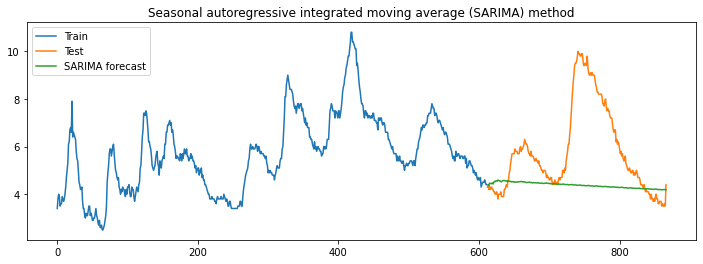

In [35]:
plt.figure(figsize=(12,4))
plt.plot(df_emp_train[COL], label='Train')
plt.plot(df_emp_test[COL], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][df_emp_test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [36]:
rmse = np.sqrt(mean_squared_error(df_emp_test[COL], y_hat_sarima['sarima_forecast'][df_emp_test.index.min()-1:])).round(2)
mape = np.round(np.mean(np.abs(df_emp_test[COL]-y_hat_sarima['sarima_forecast'][df_emp_test.index.min()-1:])/df_emp_test[COL])*100,2)

tempResults = pd.DataFrame({'Method':['SARIMA'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR),2.07,21.50
0,Moving Average (MA),2.03,21.60
0,ARIMA,2.08,21.62
0,SARIMA,2.28,22.39
